In [1]:
import os
import torch
from torch import nn
import dl4wm

print(torch.__version__)

NameError: name 'Encoder' is not defined

首先，下载一个由Tatoeba项目的双语句子对组成的“英－法”数据集，数据集中的每一行都是制表符分隔文本序列对，序列对由英文文本序列和翻译后的法语文本序列组成。请注意，每个文本序列可以是一个句子，也可以是包含多个句子的一个段落。在这个将英语翻译成法语的机器翻译问题中，英语是 源语言（source language），法语是 目标语言（target language）。

In [2]:
dl4wm.DATA_HUB['fra-eng'] = (dl4wm.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

raw_text = dl4wm.read_data_nmt()
print(len(raw_text))
print(raw_text[:75])

11489286
Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



下载数据集后，我们对原始的文本数据进行处理需要经过几个预处理步骤。例如，我们用空格代替 不间断空格（non-breaking space），使用小写字母替换大写字母，并在单词和标点符号之间插入空格。

In [3]:
text = dl4wm.preprocess_nmt(raw_text)
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


- 标记化

与字符级标记化不同，在机器翻译中，我们更喜欢单词级标记化（最先进的模型可能使用更高级的标记化技术）。下面的 `tokenize_nmt` 函数对前 num_examples 个文本序列对进行标记，其中每个标记要么是一个单词，要么是一个标点符号。此函数返回两个标记列表：source 和 target。具体地说，source[i] 是源语言（这里是英语）第 𝑖 个文本序列的标记列表，target[i] 是目标语言（这里是法语）第 𝑖 个文本序列的标记列表。

In [28]:
source, target = dl4wm.tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

让我们绘制每个文本序列所包含的标记数量的直方图。在这个简单的“英－法”数据集中，大多数文本序列的标记数量少于 20 个。

- 词汇表

由于机器翻译数据集由语言对组成，因此我们可以分别为源语言和目标语言构建两个词汇表。使用单词级标记化时，词汇量将明显大于使用字符级标记化时的词汇量。为了缓解这一问题，这里我们将出现次数少于2次的低频率标记视为相同的未知（“`<unk>`”）标记。除此之外，我们还指定了额外的特定标记，例如在小批量时用于将序列填充到相同长度的填充标记（“`<pad>`”），以及序列的开始标记（“`<bos>`”）和结束标记（“`<eos>`”）。这些特殊标记在自然语言处理任务中比较常用。

In [29]:
src_vocab = dl4wm.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [35]:
tgt_vocab = dl4wm.Vocab(target, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(tgt_vocab)

17851

- 加载数据集

回想一下，语言模型中的序列样本都有一个固定的长度，无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。这个固定长度是由 `num_steps`（时间步数或标记数量）参数指定的。在机器翻译中，每个样本都是由源和目标组成的文本序列对，其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过 截断（truncation）和 填充（padding）方式实现一次只处理一个小批量的文本序列。假设同一个小批量中的每个序列都应该具有相同的长度 `num_steps`，那么如果文本序列的标记数目少于 `num_steps` 时，我们将继续在其末尾添加特定的“<pad>”标记，直到其长度达到 `num_steps`；反之，我们将截断文本序列，只取其前 `num_steps` 个标记，并且丢弃剩余的标记。这样，每个文本序列将具有相同的长度，以便以相同形状的小批量进行加载。

如前所述，下面的 `truncate_pad` 函数将截断或填充文本序列。
    
```python
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列。"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

```

In [30]:
dl4wm.truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，可以将文本序列转换成小批量数据集用于训练。我们将特定的“`<eos>`”标记添加到所有序列的末尾，用于表示序列的结束。当模型通过一个标记接一个标记地生成序列进行预测时，生成了“`<eos>`”标记说明完成了序列输出工作。此外，我们还记录了每个文本序列的长度，统计长度时排除了填充标记，在稍后将要介绍的一些模型会需要这个长度信息。

```python
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量。"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len
```

最后，我们定义 `load_data_nmt` 函数来返回数据迭代器，以及源语言和目标语言的两种词汇表。

```python
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表。"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab
```

让我们读出“英语－法语”数据集中的第一个小批量数据。

In [12]:
train_iter, src_vocab, tgt_vocab = dl4wm.load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[61, 10,  4,  3,  1,  1,  1,  1],
        [42,  8, 11,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[  0,   8,   4,   3,   1,   1,   1,   1],
        [  0, 102,   9,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([4, 4])


In [13]:
len(train_iter)

301

In [14]:
len(src_vocab), len(tgt_vocab)

(184, 201)

# Transformer

In [1]:
import os
import torch
from torch import nn
import dl4wm

print(torch.__version__)

1.9.0


In [2]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = dl4wm.EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [3]:
encoder = dl4wm.TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [4]:
decoder_blk = dl4wm.DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [7]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, dl4wm.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = dl4wm.load_data_nmt(batch_size, num_steps)

encoder = dl4wm.TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = dl4wm.TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = dl4wm.EncoderDecoder(encoder, decoder)

loss 0.031, 3620.8 tokens/sec on cpu


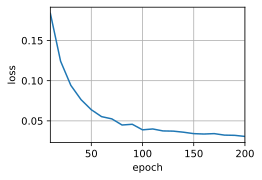

In [8]:
dl4wm.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [47]:
import math
import collections


def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = dl4wm.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    print('enc_X.shape:', enc_X.shape, src_tokens)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    print('enc_outputs.shape:', enc_outputs.shape)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    print('dec_X.shape (before loop):', dec_X.shape)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        print('====loop====')
        Y, dec_state = net.decoder(dec_X, dec_state)
        print('Y.shape:', Y.shape)
        print('dec_state[2][0].shape', dec_state[2][0].shape)
        print('dec_state[2][1].shape', dec_state[2][1].shape)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        print('dec_X.shape:', dec_X.shape)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        print('pred', pred)
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        print('output_seq.len:', len(output_seq))
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


In [48]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {dl4wm.bleu(translation, fra, k=2):.3f}')

enc_X.shape: torch.Size([1, 10]) [9, 4, 3, 1, 1, 1, 1, 1, 1, 1]
enc_outputs.shape: torch.Size([1, 10, 32])
dec_X.shape (before loop): torch.Size([1, 1])
====loop====
Y.shape: torch.Size([1, 1, 201])
dec_state[2][0].shape torch.Size([1, 1, 32])
dec_state[2][1].shape torch.Size([1, 1, 32])
dec_X.shape: torch.Size([1, 1])
pred 16
output_seq.len: 1
====loop====
Y.shape: torch.Size([1, 1, 201])
dec_state[2][0].shape torch.Size([1, 2, 32])
dec_state[2][1].shape torch.Size([1, 2, 32])
dec_X.shape: torch.Size([1, 1])
pred 5
output_seq.len: 2
====loop====
Y.shape: torch.Size([1, 1, 201])
dec_state[2][0].shape torch.Size([1, 3, 32])
dec_state[2][1].shape torch.Size([1, 3, 32])
dec_X.shape: torch.Size([1, 1])
pred 3
go . => va !,  bleu 1.000
enc_X.shape: torch.Size([1, 10]) [6, 20, 4, 3, 1, 1, 1, 1, 1, 1]
enc_outputs.shape: torch.Size([1, 10, 32])
dec_X.shape (before loop): torch.Size([1, 1])
====loop====
Y.shape: torch.Size([1, 1, 201])
dec_state[2][0].shape torch.Size([1, 1, 32])
dec_state[2][1

In [31]:
len(dec_attention_weight_seq[0][0][0])

4

In [ ]:
# je vais bien . => I'm fine .  (Google Translation)